In [ ]:
!git clone https://github.com/karencfisher/landmark-classifier.git
%cd landmark-classifier

In [13]:
import torch
import torch.nn as nn
import sqlite3
import json

from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.train import one_epoch_test
from src.helpers import setup_env

In [2]:
# If running locally, this will download dataset (make sure you have at
# least 2 Gb of space on your hard drive)
setup_env()

GPU *NOT* available. Will use CPU (slow)
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


In [3]:
%%writefile models/model1.py
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.7) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) 
                
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(197136, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # YOUR CODE HERE: process the input tensor through the
        # feature extractor, the pooling and the final linear
        # layers (if appropriate for the architecture chosen)
        x = self.pool1(self.relu1(self.conv1(x)))
        
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)



Overwriting models/model1.py


In [3]:
%run models/model1.py
model = MyModel()
model

MyModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=197136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=1000, bias=True)
)

In [4]:
batch_size = 32        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 3        # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.4          # dropout for our model
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.0     # regularization. Increase this to combat overfitting


In [5]:
# Train

data_loaders = get_data_loaders(batch_size, valid_size)
optimizer = get_optimizer(model, opt, learning_rate, weight_decay=weight_decay)
loss = get_loss()

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
model = MyModel()

train_losses, valid_losses = optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    scheduler=scheduler
)


Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])


Validating: 100%|███████████████████████████████| 32/32 [00:09<00:00,  3.43it/s]



Epoch: 1 	Training Loss: 6.916074 	Validation Loss: 6.915877
New minimum validation loss: 6.915877. Saving model ...


Validating: 100%|███████████████████████████████| 32/32 [00:09<00:00,  3.52it/s]



Epoch: 2 	Training Loss: 6.915957 	Validation Loss: 6.915079


Validating: 100%|███████████████████████████████| 32/32 [00:09<00:00,  3.48it/s]



Epoch: 3 	Training Loss: 6.916630 	Validation Loss: 6.914526
New minimum validation loss: 6.914526. Saving model ...
Time taken: 00:08:04.429


In [15]:
scheduler.state_dict()

{'gamma': 0.9,
 'base_lrs': [0.001],
 'last_epoch': 3,
 '_step_count': 4,
 '_is_initial': False,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.000729]}

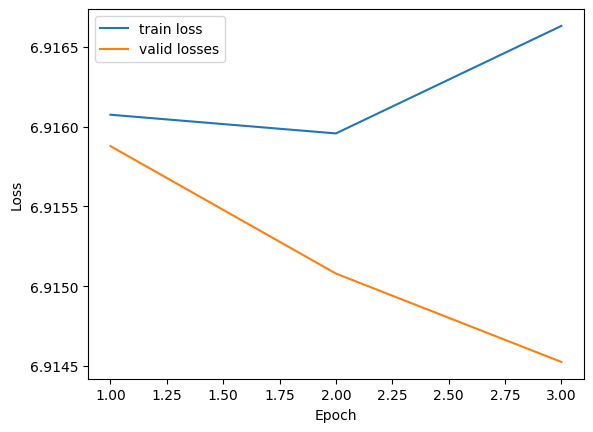

In [6]:
import matplotlib.pyplot as plt

x = range(1, num_epochs+1)
plt.plot(x, train_losses, label='train loss')
plt.plot(x, valid_losses, label='valid losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# test
test_loss, accuracy = one_epoch_test(data_loaders['test'], model, loss)


Testing: 100%|██████████████████████████████████| 40/40 [00:11<00:00,  3.61it/s]

Test Loss: 6.918526


Test Accuracy:  0% ( 0/1250)


In [18]:
# log experiment
file_name = input("File name: ")

conn = sqlite3.connect('experiments.db')
cursor = conn.cursor()

sql = '''
INSERT INTO experiments (batch_size, num_epochs, dropout, learning_rate, optimizer, 
weight_decay, scheduler, Accuracy, train_losses, valid_losses, model_file, scheduler_params)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
'''
train_losses_serial = json.dumps(train_losses).encode('utf-8')
valid_losses_serial = json.dumps(valid_losses).encode('utf-8')
scheduler_params = json.dumps(scheduler.state_dict())

values = (batch_size, num_epochs, dropout, learning_rate, opt, weight_decay, str(scheduler), 
          accuracy.tolist(), train_losses_serial, valid_losses_serial, file_name, scheduler_params)

cursor.execute(sql, values)
conn.commit()

conn.close()